In [149]:
# Import libraries that will be needed for the lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import os, datetime

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras import optimizers, layers, losses, regularizers 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [201]:
# Download the dataset
dataset = pd.read_csv('test.csv')
raw_data = dataset.values
dataset.head()

,Index,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload
0,0,1.510823e+09,26513,0,0,0,0,64788,80,6,573626374,464166401,A,8192,38580,40,IP / TCP 192.168.0.26:64788 > 104.20.31.2:http A
1,1,1.510823e+09,22967,1,1,1,1,80,64788,6,464166401,573626375,A,42,46729,40,IP / TCP 104.20.31.2:http > 192.168.0.26:64788...
2,2,1.510823e+09,41679,0,0,2,0,64750,80,6,85789174,716926315,A,4096,53245,40,IP / TCP 192.168.0.26:64750 > 54.230.51.182:ht...
3,3,1.510823e+09,16922,2,1,1,1,80,64750,6,716926315,85789175,A,122,49439,52,IP / TCP 54.230.51.182:http > 192.168.0.26:647...
4,4,1.510823e+09,64535,0,0,3,0,64789,443,6,2110653899,454639098,A,4096,18968,40,IP / TCP 192.168.0.26:64789 > 172.217.12.163:h...


In [202]:
encoder = OrdinalEncoder(dtype=int)
#h_encoder = OneHotEncoder(drop='first', handle_unknown='error')
#h_encoder.fit(dataset[['TCP Flag']])
#tcp_flag = dataset.columns[12]
#payload = dataset.columns[15]
#dataset = pd.get_dummies(dataset, columns=["TCP_Flag", "Payload"], prefix=['TCP_Flag', 'Payload'], drop_first=True, dtype=int)
#dataset['TCP Flag'] = h_encoder.transform(dataset[['TCP Flag']])
dataset['TCP_Flag'] = encoder.fit_transform(dataset[['TCP_Flag']])#, dataset[['Payload']])
#dataset['Payload'] = encoder.fit_transform(dataset[['Payload']])

In [203]:
dataset.head()

,Index,Time,Identifier,Src_IP,Src_MAC,Dest_IP,Dest_MAC,Src_Port,Dest_Port,Proto,Seq_Num,Ack_Num,TCP_Flag,Window_Size,TCP_Checksum,Packet_Length,Payload
0,0,1.510823e+09,26513,0,0,0,0,64788,80,6,573626374,464166401,0,8192,38580,40,IP / TCP 192.168.0.26:64788 > 104.20.31.2:http A
1,1,1.510823e+09,22967,1,1,1,1,80,64788,6,464166401,573626375,0,42,46729,40,IP / TCP 104.20.31.2:http > 192.168.0.26:64788...
2,2,1.510823e+09,41679,0,0,2,0,64750,80,6,85789174,716926315,0,4096,53245,40,IP / TCP 192.168.0.26:64750 > 54.230.51.182:ht...
3,3,1.510823e+09,16922,2,1,1,1,80,64750,6,716926315,85789175,0,122,49439,52,IP / TCP 54.230.51.182:http > 192.168.0.26:647...
4,4,1.510823e+09,64535,0,0,3,0,64789,443,6,2110653899,454639098,0,4096,18968,40,IP / TCP 192.168.0.26:64789 > 172.217.12.163:h...


In [174]:
lab = raw_data[:, -1]

lab.shape

(1477,)

In [126]:
train_data, test_data = train_test_split(
    dataset, test_size=0.2, random_state=42
)

In [127]:
test_data.head()

,Index,Time,Identifier,Src IP,Src MAC,Dest IP,Dest MAC,Src Port,Dest Port,Proto,Seq Num,Ack Num,TCP Flag,TCP checksum,Packet Length,Payload
242,242,1.510823e+09,36175,0,0,19,0,64857,443,6,3447194843,0,4.0,29180,40,115.0
585,585,1.510823e+09,35361,15,1,1,1,443,64864,6,3648371366,4238189773,2.0,36955,83,42.0
1290,1290,1.510823e+09,2134,0,0,27,0,64507,443,6,3118363782,3433623557,0.0,48800,52,73.0
1362,1362,1.510823e+09,8464,20,1,1,1,443,64507,6,3433669726,3118363782,3.0,5162,1438,158.0
439,439,1.510823e+09,54784,15,1,1,1,443,64862,6,3420182035,4072855761,2.0,54184,83,36.0


#### Normalize the data to [0,1]

In [128]:
scaling = MinMaxScaler()
train_data = scaling.fit_transform(train_data)
test_data = scaling.fit_transform(test_data)
#train_data= min_max_train.transform(train_data)



In [129]:
test_data

array([[0.15384615, 0.31903601, 0.55214677, ..., 0.4454865 , 0.        ,
        0.52857143],
       [0.38942308, 0.49860784, 0.53972251, ..., 0.56482832, 0.03006993,
        0.18095238],
       [0.87362637, 0.96810779, 0.0325717 , ..., 0.74664231, 0.00839161,
        0.32857143],
       ...,
       [0.25892857, 0.34688461, 0.06068654, ..., 0.58654776, 0.00839161,
        0.6952381 ],
       [0.60645604, 0.78816158, 0.83982783, ..., 0.06650908, 0.01678322,
        0.32857143],
       [0.18131868, 0.32287645, 0.38141246, ..., 0.32743404, 0.19090909,
        0.33333333]])

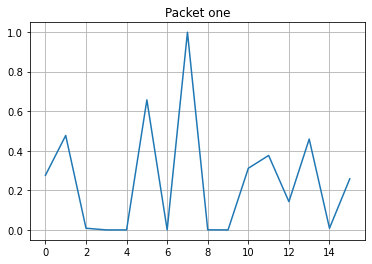

In [130]:
plt.grid()
plt.plot(np.arange(16), train_data[5])
plt.title("Packet one")
plt.show()

In [131]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = layers.Dense(16, activation="relu", activity_regularizer=regularizers.l1(10e-5))#tf.keras.Sequential([
         # layers.Dense(16, activation="relu", activity_regularizer=regularizers.l1(10e-5))#,
          #layers.Dropout(0.1),
          #layers.Dense(4, activation="relu"),
          #layers.Dropout(0.1),
          #layers.Dense(2, activation="relu"),
          #layers.Dropout(0.1)
      #  ])

        self.decoder = layers.Dense(16, activation="sigmoid")#tf.keras.Sequential([
          #layers.Dense(16, activation="relu")#,
          #layers.Dense(4, activation="relu"),
          #layers.Dense(16, activation="sigmoid")
        #])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [132]:
autoencoder.compile(optimizer='adam', loss='mae')

In [141]:
history = autoencoder.fit(train_data, train_data, 
          epochs=150, 
          batch_size=256,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/150
5/5 [==============================] - 0s 24ms/step - loss: 0.0800 - val_loss: 0.0855
Epoch 2/150
5/5 [==============================] - 0s 14ms/step - loss: 0.0795 - val_loss: 0.0850
Epoch 3/150
5/5 [==============================] - 0s 9ms/step - loss: 0.0789 - val_loss: 0.0845
Epoch 4/150
5/5 [==============================] - 0s 8ms/step - loss: 0.0784 - val_loss: 0.0839
Epoch 5/150
5/5 [==============================] - 0s 9ms/step - loss: 0.0779 - val_loss: 0.0834
Epoch 6/150
5/5 [==============================] - 0s 8ms/step - loss: 0.0774 - val_loss: 0.0829
Epoch 7/150
5/5 [==============================] - 0s 12ms/step - loss: 0.0769 - val_loss: 0.0824
Epoch 8/150
5/5 [==============================] - 0s 13ms/step - loss: 0.0764 - val_loss: 0.0819
Epoch 9/150
5/5 [==============================] - 0s 11ms/step - loss: 0.0759 - val_loss: 0.0814
Epoch 10/150
5/5 [==============================] - 0s 11ms/step - loss: 0.0754 - val_loss: 0.0810
Epoch 11/150
5/5 [=====

5/5 [==============================] - 0s 9ms/step - loss: 0.0503 - val_loss: 0.0565
Epoch 85/150
5/5 [==============================] - 0s 8ms/step - loss: 0.0500 - val_loss: 0.0565
Epoch 86/150
5/5 [==============================] - 0s 12ms/step - loss: 0.0497 - val_loss: 0.0561
Epoch 87/150
5/5 [==============================] - 0s 8ms/step - loss: 0.0494 - val_loss: 0.0558
Epoch 88/150
5/5 [==============================] - 0s 12ms/step - loss: 0.0491 - val_loss: 0.0555
Epoch 89/150
5/5 [==============================] - 0s 8ms/step - loss: 0.0488 - val_loss: 0.0552
Epoch 90/150
5/5 [==============================] - 0s 11ms/step - loss: 0.0486 - val_loss: 0.0550
Epoch 91/150
5/5 [==============================] - 0s 9ms/step - loss: 0.0483 - val_loss: 0.0546
Epoch 92/150
5/5 [==============================] - 0s 8ms/step - loss: 0.0480 - val_loss: 0.0543
Epoch 93/150
5/5 [==============================] - 0s 11ms/step - loss: 0.0477 - val_loss: 0.0541
Epoch 94/150
5/5 [===========

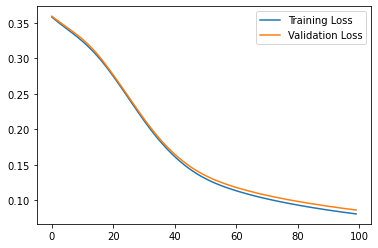

In [134]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

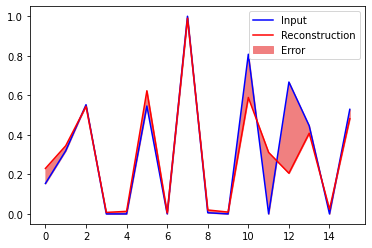

In [135]:
encoded_data = autoencoder.encoder(test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(16), decoded_data[0], test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

37/37 [==============================] - 0s 1ms/step


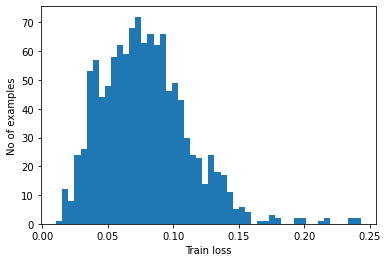

In [136]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [137]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold) 

Threshold:  0.11226534765788629


In [138]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold) #Returns the truth value of (loss < threshold) element-wise.

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [139]:
pred_ = predict(autoencoder, test_data, threshold)


In [140]:
pred_

<tf.Tensor: shape=(296,), dtype=bool, numpy=
array([ True,  True,  True,  True, False, False,  True,  True,  True,
       False,  True, False,  True, False,  True,  True, False,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True, False,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  Tr